<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/jaxemulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 202 kB 6.9 MB/s 
     |████████████████████████████████| 145 kB 59.7 MB/s 
     |████████████████████████████████| 9.1 MB 56.0 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 217 kB 48.9 MB/s 
     |████████████████████████████████| 51 kB 5.7 MB/s 
     |████████████████████████████████| 72 kB 319 kB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import random
import statistics
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit
from flax import linen as nn
from flax.training import train_state,checkpoints
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
def npy_loader(path):
    return jnp.load(path)

In [ ]:
class SimpleMLP(nn.Module):
    features:Sequence[int]

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            if i != len(self.features)-1:
                x=nn.relu(x)
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
layer_sizes=[64,256,256,256]
learning_rate=1e-6
model=SimpleMLP(features=layer_sizes)
temp=jnp.ones(2)
params=model.init(jax.random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate,b1=0.9,b2=0.999)
opt_state=tx.init(params)
state=train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
restored_state=checkpoints.restore_checkpoint(ckpt_dir="/content/drive/My Drive/Colab Notebooks/checkpoint_0",target=state)

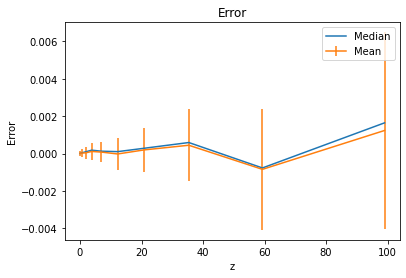

In [ ]:
cosmo=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
cosmo_num=random.randrange(1000)
parameters=np.array([cosmo[cosmo_num,0],cosmo[cosmo_num,2]])
input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
z=npy_loader("/content/drive/My Drive/Colab Notebooks/999.npy")[0,:]
d_data=input_result[cosmo_num,:]
d_test=restored_state.apply_fn(restored_state.params,parameters)
discrepancy=d_test/d_data
plt.subplot(211)
plt.plot(z,d_data,label="Reference")
plt.plot(z,d_test,label="Fitting")
plt.ylabel("D")
plt.title("Omega_m="+str(round(parameters[0],3))+", H0="+str(round(parameters[1],3)))
plt.legend()
plt.subplot(212)
plt.plot(z,discrepancy,label="Discrepancy")
plt.xlabel("z")
plt.ylabel("Predict/Data")
plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/cosmo"+str(cosmo_num)+".png")
z_plot=[]
med=[]
mean_error=[]
std=[]
for i in range(10):
    plt.clf()
    temp=[]
    for j in range(1000):
        cosmo_num=j
        d_data=input_result[cosmo_num,:]
        parameters[0]=cosmo[cosmo_num,0]
        parameters[1]=cosmo[cosmo_num,2]
        d_test=restored_state.apply_fn(restored_state.params,parameters)
        temp.append((d_test[i*28]/d_data[i*28]-1).item())
        plt.scatter(cosmo[cosmo_num,0].item(),cosmo[cosmo_num,2].item(),c=temp[-1],cmap='coolwarm',vmin=-0.02,vmax=0.02)
    plt.colorbar()
    plt.xlabel("Omega_m")
    plt.ylabel("H0")
    plt.title("Error of Cosmos (z="+str(round(z[i*28].item(),3))+")")
    plt.savefig("/content/drive/My Drive/Colab Notebooks/error"+str(i)+".png")
    z_plot.append(z[i*28].item())
    med.append(statistics.median(temp))
    mean_error.append(statistics.mean(temp))
    std.append(statistics.stdev(temp))
plt.clf()
plt.plot(z_plot,med,label="Median")
plt.errorbar(z_plot,mean_error,std,label="Mean")
plt.xlabel("z")
plt.ylabel("Error")
plt.title("Error")
plt.legend()
plt.savefig("/content/drive/My Drive/Colab Notebooks/centralerror.png")
